# Parameter Inference

Here we infer the parameters of the systems we have observed.

In [1]:
%pylab inline
%config InlineBackend.figure_format = 'retina'

Populating the interactive namespace from numpy and matplotlib


In [2]:
import arviz as az
import astropy.cosmology as cosmo
from astropy.cosmology import Planck15
import astropy.units as u
import corner
import h5py
import multiprocessing as multi
import pystan
import scipy.integrate as si
from scipy.integrate import cumtrapz
from scipy.interpolate import interp1d, RectBivariateSpline
import scipy.stats as ss
import seaborn as sns
import sys
from tqdm import tqdm, tqdm_notebook
from true_params import uncert

sns.set_context('notebook')
sns.set_style('ticks')
sns.set_palette('colorblind')

/Users/wfarr/anaconda3/lib/python3.7/site-packages/dask/config.py:168: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  data = yaml.load(f.read()) or {}
/Users/wfarr/anaconda3/lib/python3.7/site-packages/distributed/config.py:20: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  defaults = yaml.load(f)


In [3]:
with h5py.File('observations.h5', 'r') as f:
    m1s = array(f['m1s'])
    m2s = array(f['m2s'])
    zs = array(f['zs'])
    dls = Planck15.luminosity_distance(zs).to(u.Gpc).value
    thetas = array(f['thetas'])
    
    mcobs = array(f['mcobs'])
    etaobs = array(f['etaobs'])
    rhoobs = array(f['rhoobs'])
    thetaobs = array(f['thetaobs'])
    
    sigma_mc = array(f['sigma_mc'])
    sigma_eta = array(f['sigma_eta'])
    sigma_rho = array(f['sigma_rho'])
    sigma_theta = array(f['sigma_t'])

We can proceed analytically, since the likelihood is separable in $\mathcal{M}, \eta, \theta, \rho$.

In [4]:
def draw_mc(mc_obs, sigma_obs, size=10000):
    return exp(log(mc_obs) + sigma_obs*randn(size))

def draw_eta(eta_obs, sigma_eta, size=10000):
    ets = linspace(0, 0.25, 1000)
    pe = ss.norm(ets, sigma_eta)
    pets = pe.pdf(eta_obs) / (pe.cdf(0.25) - pe.cdf(0.0))
    cets = cumtrapz(pets, ets, initial=0)
    cets /= cets[-1]
    icdf = interp1d(cets, ets)
    
    return icdf(rand(size))

def draw_theta(theta_obs, sigma_theta, size=10000):
    ths = linspace(0, 1, 1000)
    pt = ss.norm(ths, sigma_theta)
    pths = pt.pdf(theta_obs) / (pt.cdf(1) - pt.cdf(0))
    cths = cumtrapz(pths, ths, initial=0)
    cths /= cths[-1]
    icdf = interp1d(cths, ths)
    
    return icdf(rand(size))

def draw_rho(rho_obs, size=10000):
    return rho_obs + randn(size) # Hope nothing negative!

Once we have drawn from the likelihoods, we then need to re-weight to get likelihood in $m_1$, $m_2$, $\theta$, $d_L$ space.  Happily, this can be accomplished by two transformations.  The first is 
$$
\mathcal{M}, \eta \mapsto m_1, m_2
$$
which has determinant 
$$
\left| \frac{\partial \left( m_1, m_2 \right)}{\partial \left( \mathcal{M}, \eta \right)} \right| = \frac{\left( m_1 + m_2 \right)^2}{\left( m_1 - m_2 \right) \eta^{3/5}}.
$$
The flat prior in $\mathcal{M}$-$\eta$ space implies a prior that is proportional to $\left| \partial \left( \mathcal{M}, \eta \right) / \partial \left( m_1, m_2 \right) \right|$, so to undo this prior we need to weight the transformed samples by $\left| \partial \left(m_1, m_2 \right) / \partial \left( \mathcal{M}, \eta \right) \right|$.

The second transformation is 
$$
\rho \mapsto d_L = \frac{\rho_{\mathrm{opt}}\left( m_1, m_2, 1 \, \mathrm{Gpc} \right) \theta}{\rho}
$$
and the Jacobian we need to correct the density is 
$$
\left| \frac{\mathrm{d} d_L}{\mathrm{d} \rho} \right| = \frac{\rho_{\mathrm{opt}}\left( m_1, m_2, 1 \, \mathrm{Gpc} \right) \theta}{\rho^2}
$$

We also need to weight by the population in $\theta$, which we obtain by Monte-Carlo with *lots* of points and then collapse into a histogram.

Text(0, 0.5, '$p\\left(\\Theta \\right)$')

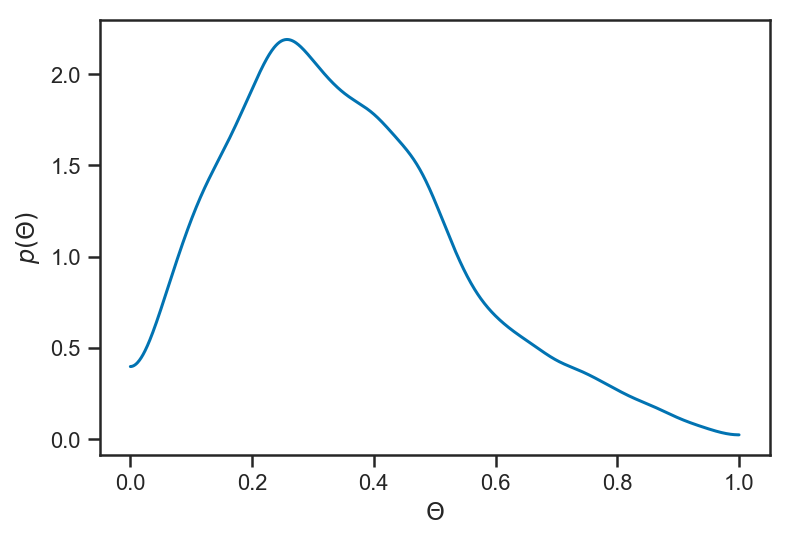

In [5]:
with h5py.File('thetas.h5', 'r') as f:
    t = array(f['Theta'])
kde = ss.gaussian_kde(t)
ts = linspace(0, 1, 1000)
ps = kde(ts) + kde(-ts) + kde(2-ts)
ptheta = interp1d(ts, ps)

plot(ts, ps)
xlabel(r'$\Theta$')
ylabel(r'$p\left(\Theta \right)$')

In [6]:
with h5py.File('optimal_snr.h5', 'r') as inp:
    ms = array(inp['ms'])
    osnrs = array(inp['SNR'])

osnr_interp = RectBivariateSpline(ms, ms, osnrs)

def optimal_snr(m1obs, m2obs, dl):
    return osnr_interp.ev(m1obs, m2obs)/dl

In [7]:
def mcetathetarho_to_m1m2thetadl(mc, eta, theta, rho):
    disc = 1.0 - 4.0*eta
    m1 = 0.5*(1 + sqrt(disc))*mc/eta**(3.0/5.0)
    m2 = 0.5*(1 - sqrt(disc))*mc/eta**(3.0/5.0)
    
    dl = optimal_snr(m1, m2, 1)*theta/rho
    
    mwt = (m1+m2)**2 / (eta**(3.0/5.0)*(m1-m2))
    dlwt = optimal_snr(m1, m2, 1)*theta/(rho*rho)
    
    wt = mwt*dlwt*ptheta(theta)
    wt /= np.max(wt)
    r = rand(len(mc))
    s = r < wt
    
    return m1[s], m2[s], theta[s], dl[s]

In [8]:
mcs = draw_mc(mcobs[0], sigma_mc[0])
etas = draw_eta(etaobs[0], sigma_eta[0])
thetas = draw_theta(thetaobs[0], sigma_theta[0])
rhos = draw_rho(rhoobs[0])

In [11]:
m1 = empty((0,))
m2 = empty((0,))
theta = empty((0,))
dl = empty((0,))

while len(m1) < 4000:
    a, b, c, d = mcetathetarho_to_m1m2thetadl(draw_mc(mcobs[0], sigma_mc[0]),
                                              draw_eta(etaobs[0], sigma_eta[0]),
                                              draw_theta(thetaobs[0], sigma_theta[0]),
                                              draw_rho(rhoobs[0]))
    
    m1 = concatenate((m1, a))
    m2 = concatenate((m2, b))
    theta = concatenate((theta, c))
    dl = concatenate((dl, d))
m1 = m1[:4000]
m2 = m2[:4000]
theta = theta[:4000]
dl = dl[:4000]

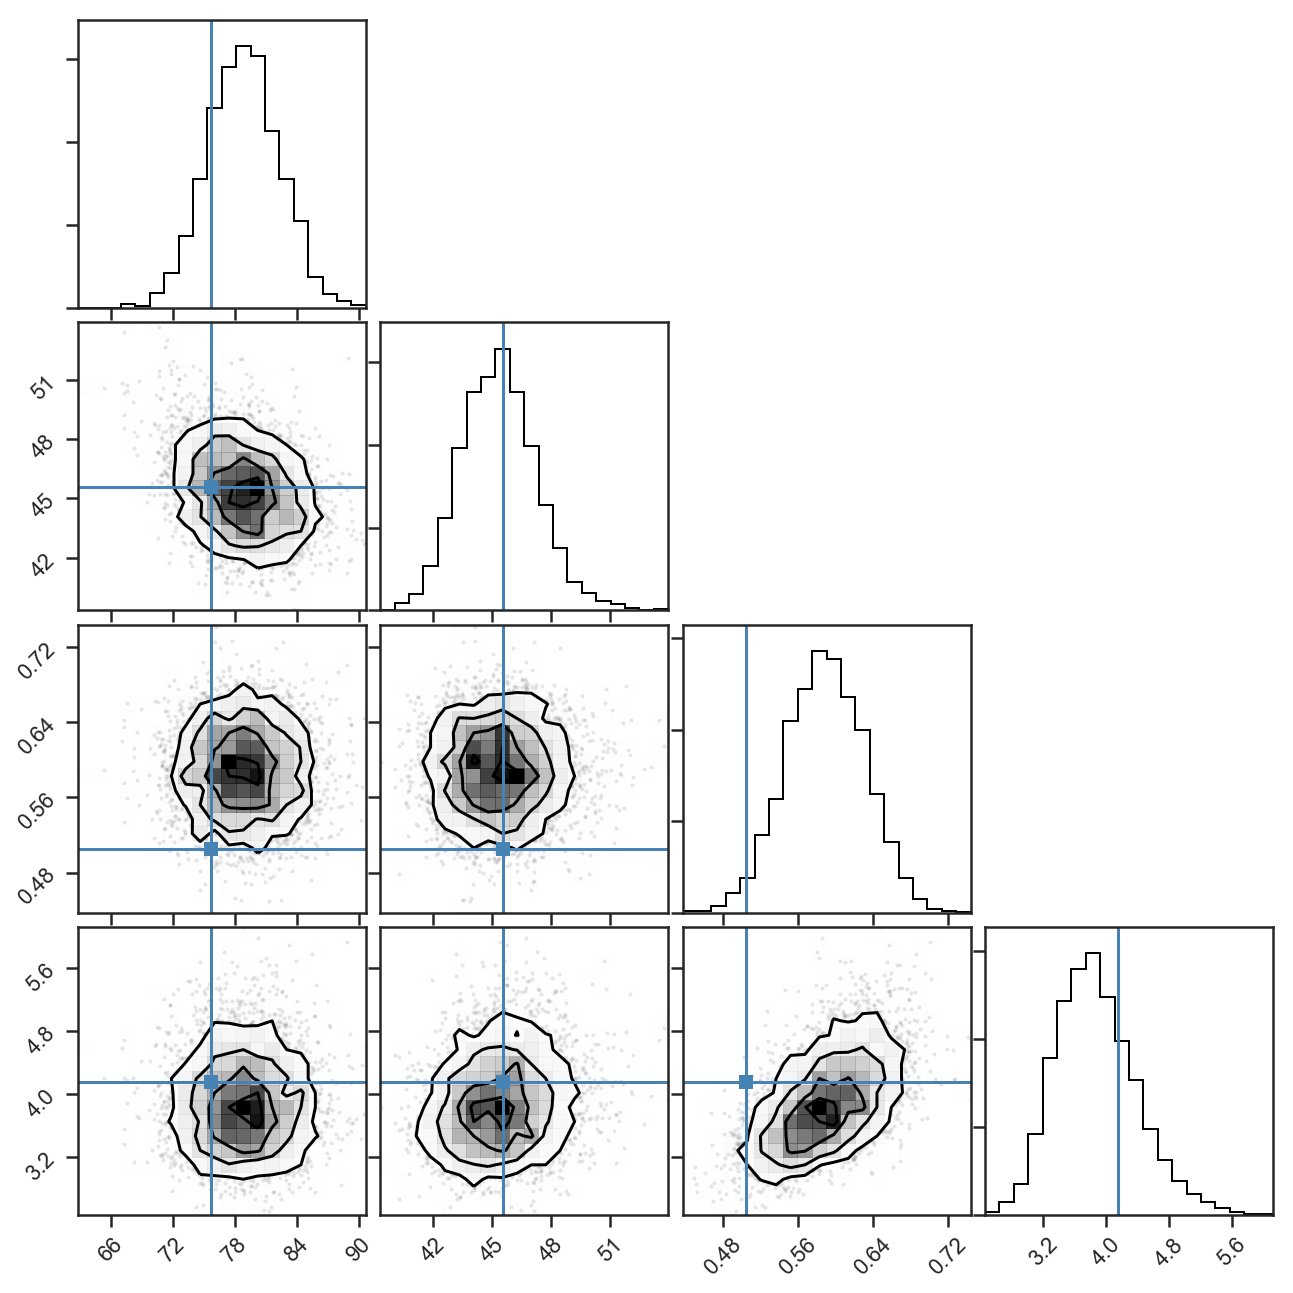

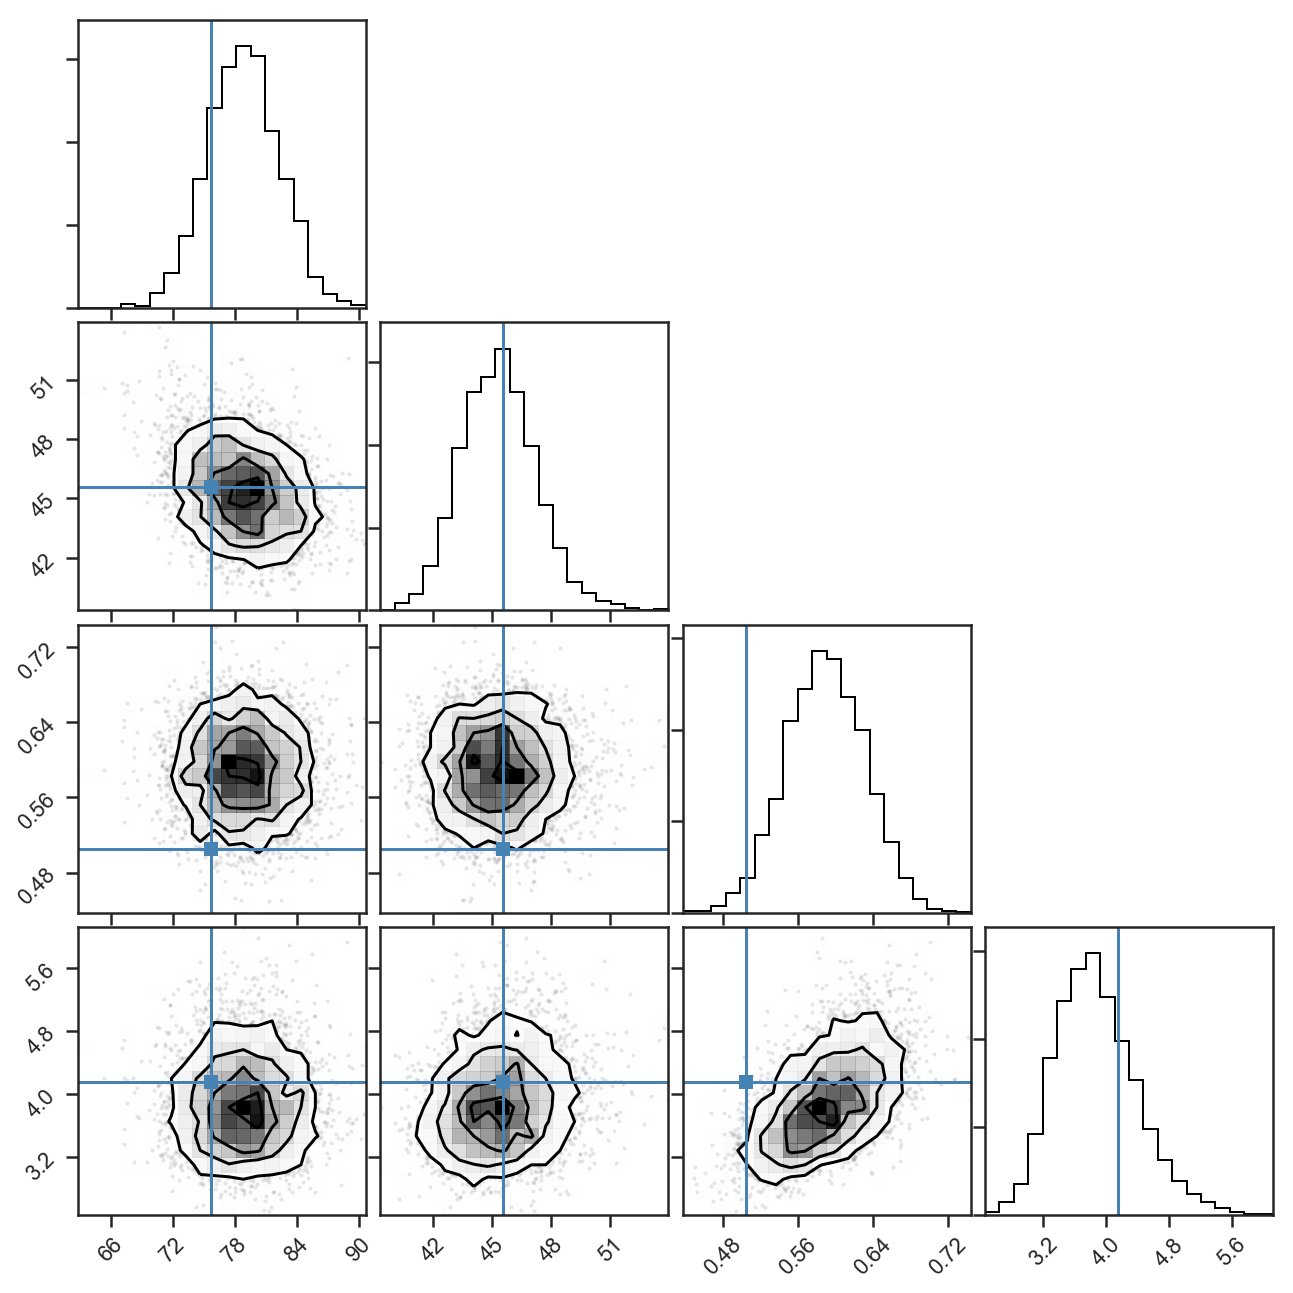

In [12]:
corner.corner(column_stack((m1, m2, theta, dl)),
              truths=[m1s[0]*(1+zs[0]), m2s[0]*(1+zs[0]), thetas[0], Planck15.luminosity_distance(zs[0]).to(u.Gpc).value])

In [13]:
def draw_posterior(i):
    m1 = empty((0,))
    m2 = empty((0,))
    theta = empty((0,))
    dl = empty((0,))

    while len(m1) < 4000:
        a, b, c, d = mcetathetarho_to_m1m2thetadl(draw_mc(mcobs[i], sigma_mc[i]),
                                                  draw_eta(etaobs[i], sigma_eta[i]),
                                                  draw_theta(thetaobs[i], sigma_theta[i]),
                                                  draw_rho(rhoobs[i]))

        m1 = concatenate((m1, a))
        m2 = concatenate((m2, b))
        theta = concatenate((theta, c))
        dl = concatenate((dl, d))
    m1 = m1[:4000]
    m2 = m2[:4000]
    theta = theta[:4000]
    dl = dl[:4000]
    
    return (m1, m2, theta, dl)

In [14]:
pool = multi.Pool()
try:
    posteriors = list(tqdm_notebook(pool.imap(draw_posterior, range(len(m1s))), total=len(m1s)))
finally:
    pool.close()

In [15]:
m1post, m2post, thetapost, dlpost = zip(*posteriors)

In [16]:
with h5py.File('observations.h5', 'a') as f:
    try:
        del f['posteriors']
    except:
        pass # Maybe it doesn't exist yet?
    pg = f.create_group('posteriors')
    
    pg.create_dataset('m1det', data=array(m1post), compression='gzip', shuffle=True, chunks=(1, 4000))
    pg.create_dataset('m2det', data=array(m2post), compression='gzip', shuffle=True, chunks=(1, 4000))
    pg.create_dataset('theta', data=array(thetapost), compression='gzip', shuffle=True, chunks=(1, 4000))
    pg.create_dataset('dl', data=array(dlpost), compression='gzip', shuffle=True, chunks=(1, 4000))

## Checking results

In [17]:
with h5py.File('observations.h5', 'r') as f:
    m1s = array(f['m1s']).squeeze()
    m2s = array(f['m2s']).squeeze()
    zs = array(f['zs']).squeeze()
    dls = Planck15.luminosity_distance(zs).to(u.Gpc).value
    
    m1det_samples = array(f['posteriors']['m1det'])
    m2det_samples = array(f['posteriors']['m2det'])
    dl_samples = array(f['posteriors']['dl'])
    theta_samples = array(f['posteriors']['theta'])

First, let's look at some z-scores for $m_1$, $m_2$, and $d_L$:

Text(0, 0.5, '$p\\left( z_{d_L} \\right)$')

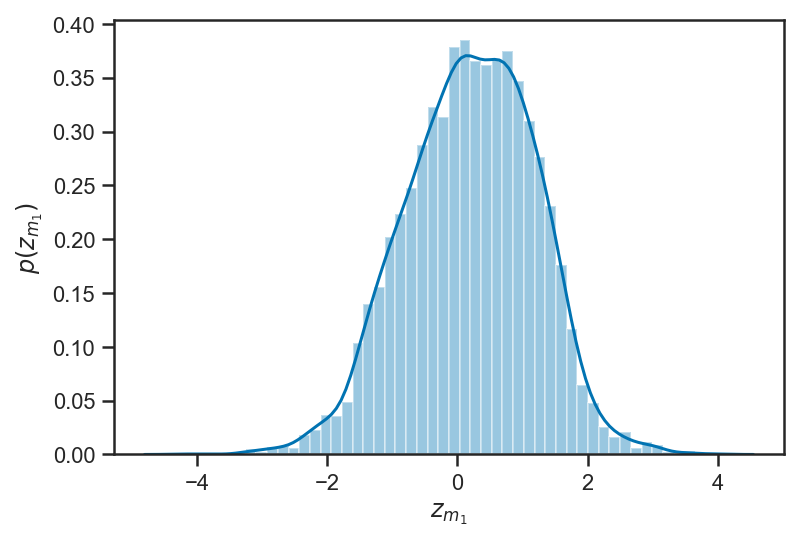

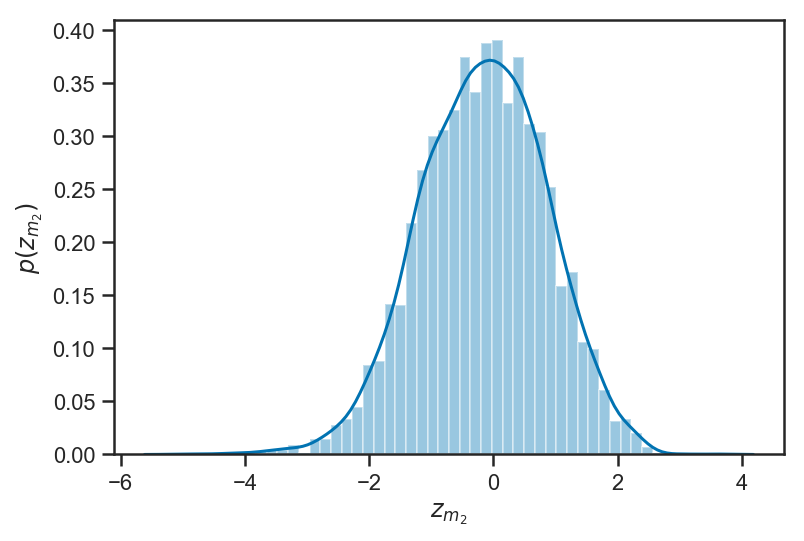

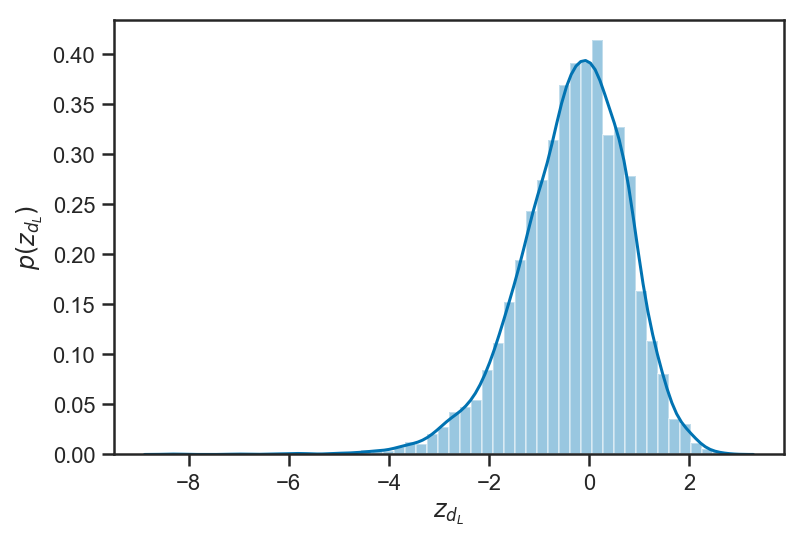

In [18]:
zscore_m1 = mean(m1det_samples - m1s[:,newaxis]*(1+zs[:,newaxis]), axis=1)/std(m1det_samples, axis=1)
sns.distplot(zscore_m1)
xlabel(r'$z_{m_1}$')
ylabel(r'$p\left( z_{m_1} \right)$')

figure()
zscore_m2 = mean(m2det_samples - m2s[:,newaxis]*(1+zs[:,newaxis]), axis=1)/std(m2det_samples, axis=1)
sns.distplot(zscore_m2)
xlabel(r'$z_{m_2}$')
ylabel(r'$p\left( z_{m_2} \right)$')

figure()
zscore_dl = mean(dl_samples - dls[:,newaxis], axis=1)/std(dl_samples, axis=1)
sns.distplot(zscore_dl)
xlabel(r'$z_{d_L}$')
ylabel(r'$p\left( z_{d_L} \right)$')

We are just looking for major outliers (since we have drawn 4M objects or so, out to $z = 3$, we expect even some 4-5 sigma outliers).  No surprises, I guess.

Another test we can do is to check the median uncertainties in masses and distances, and compare against GW170814.  The agreement is striking (well, we tuned it to be this way).

In [19]:
print('median 90% CI in log(m1) is {:.2f}'.format(median(percentile(log(m1det_samples), 95, axis=1) - percentile(log(m1det_samples), 5, axis=1))))
print('median 90% CI in log(m2) is {:.2f}'.format(median(percentile(log(m2det_samples), 95, axis=1) - percentile(log(m2det_samples), 5, axis=1))))
print('median 90% CI in log(dL) is {:.2f}'.format(median(percentile(log(dl_samples), 95, axis=1) - percentile(log(dl_samples), 5, axis=1))))

print()

print('GW170814 had {:.2f}, {:.2f}, {:.2f}'.format(log(30.5+5.7)-log(30.5-3.0), log(25.3+2.8)-log(25.3-4.2), log(540+130)-log(540-210)))

median 90% CI in log(m1) is 0.18
median 90% CI in log(m2) is 0.17
median 90% CI in log(dL) is 0.42

GW170814 had 0.27, 0.29, 0.71


Checking that our mock is consistent with O1+O2 observations in the maximum mass.  Here we show the distribution of the true maximum (source frame) mass for random draws of 10 events from our mock; in O1+O2 the corresponding upper limit was $\sim 45 \, M_\odot$, and we see that a good fraction of our mock O1+O2 catalogs would have a similar maximum upper mass limit.

In [20]:
mhigh = []
for i in range(10000):
    mhigh.append(np.max(random.choice(m1s, size=10)))
mhigh = array(mhigh)

Text(0, 0.5, '$p\\left( m_{\\mathrm{max},O1+O2} \\right)$')

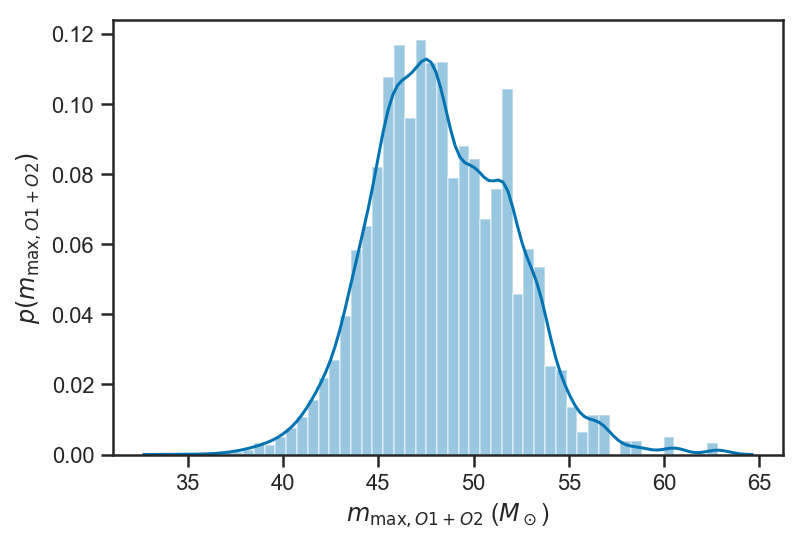

In [21]:
sns.distplot(mhigh)
xlabel(r'$m_{\mathrm{max},O1+O2}$ ($M_\odot$)')
ylabel(r'$p\left( m_{\mathrm{max},O1+O2} \right)$')

Let's see what our samples look like transformed into an unconstrained space....

In [22]:
def to_unconstrained(m1, m2, dl):
    x1 = log(m1)
    x2 = log(m2) - log(m1-m2)
    x3 = log(dl)
    
    return (x1, x2, x3)

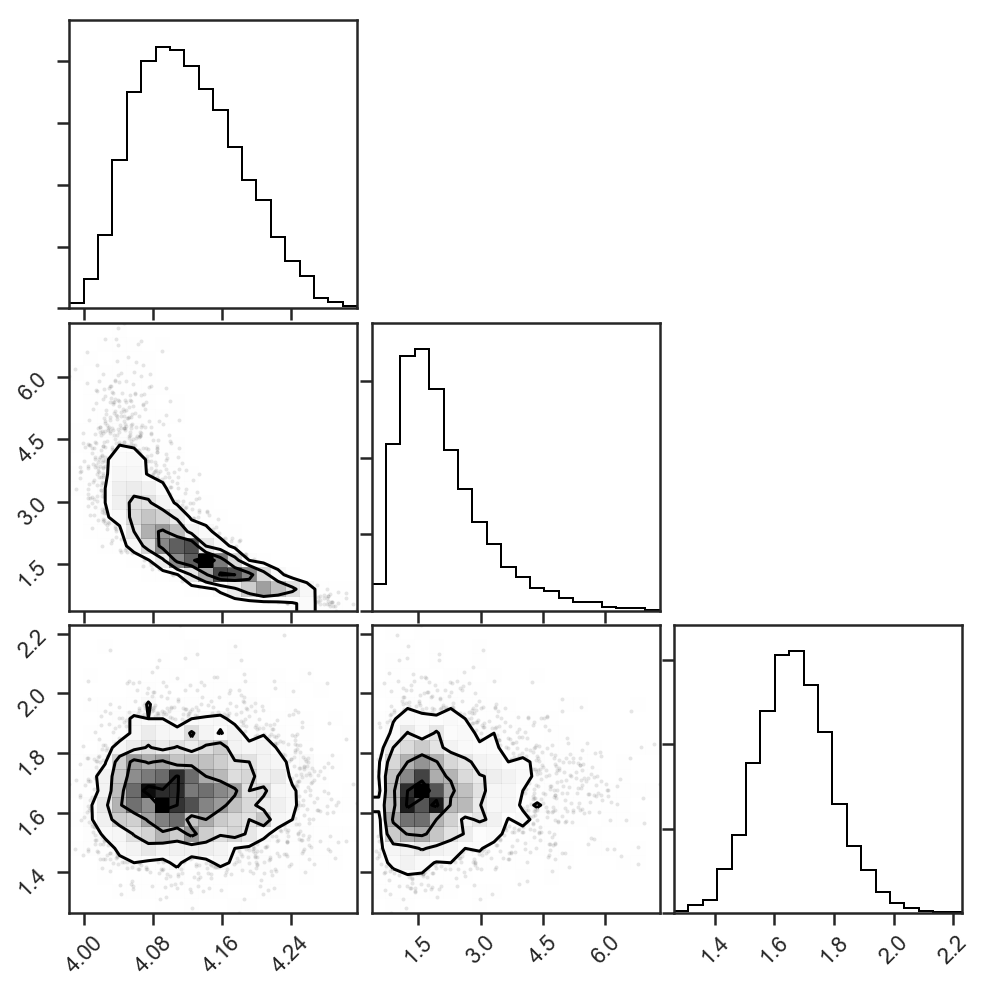

In [23]:
i = randint(m1s.shape[0])
corner.corner(column_stack(to_unconstrained(m1det_samples[i,:], m2det_samples[i,:], dl_samples[i,:])));